In [2]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo
import sys, time

# inline plotting
%matplotlib inline


# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import Scale_model
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.dynamicsampler import stopping_function, weight_function
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

from prospect.models.transforms import logsfr_ratios_to_masses
from multiprocessing import Pool
from scipy import stats
from scipy.special import erf, erfinv

import george
from george import kernels

In [3]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

In [48]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.1, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2550,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.03, irac_err = 0.06, decontam = True) 
#             phot_errterm = 0.0, decontam = True)               

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [ ]:
w,f = sp.get_spectrum(tage=3,peraa=True)

In [ ]:
plt.plot(Gs.Pwv, Gs.Pflx / Gs.Perr,'o')
plt.axhline(1/0.05)

In [1]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [ ]:
# bscale = Scale_model(Gs.Bfl,Gs.Ber, Gmfl[0])
# rscale = Scale_model(Gs.Rfl,Gs.Rer, Gmfl[1])

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

plt.plot(np.log10(Gs.Bwv_rf), PC*Gmfl[0]*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Gmfl[1]*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)

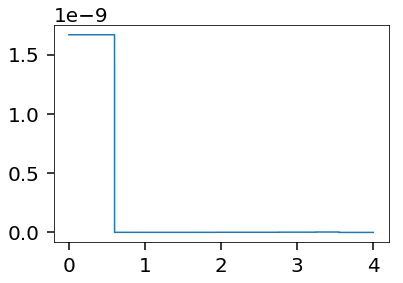

In [21]:
plt.plot(time,sfr)

In [112]:
spec = np.array([wvs[0],flxs[0],errs[0]]).T

In [113]:
spec[:,1]

array([1.57107362e-18, 1.35208755e-18, 1.45823104e-18, 1.70462941e-18,
       1.74356625e-18, 1.53248489e-18, 1.57361187e-18, 1.60159329e-18,
       1.68395725e-18, 1.41671966e-18, 1.57598689e-18, 1.64502301e-18,
       1.88350211e-18, 1.64114283e-18, 1.56581880e-18, 1.63462933e-18,
       1.63833641e-18, 1.85453295e-18, 1.66608275e-18, 1.82585708e-18,
       1.90747744e-18, 1.88706414e-18, 1.56371039e-18, 1.92680325e-18,
       1.64814597e-18, 1.69442193e-18, 2.04733074e-18, 2.00316427e-18,
       1.93626618e-18, 1.80903702e-18, 2.34950429e-18, 2.39639294e-18,
       2.41936787e-18, 2.38815491e-18, 2.84962527e-18, 2.74810904e-18,
       2.88218302e-18, 2.46685225e-18, 2.47997693e-18, 2.61648215e-18,
       2.64502947e-18, 2.73453001e-18, 2.41747517e-18, 2.37240453e-18,
       2.51911827e-18, 2.82067021e-18, 2.73100910e-18, 2.68027728e-18,
       2.64221323e-18, 2.48168540e-18, 2.54428942e-18, 2.70863379e-18,
       2.55509696e-18, 2.65919480e-18, 2.65820163e-18, 2.67025987e-18,
      

In [5]:
class noise_model(object):
    """ A class for modelling the noise properties of spectroscopic
    data, including correlated noise.
    Parameters
    ----------
    spectrum : array_like
        The spectral data to which the calibration model is applied.
    spectral_model : array_like
        The physical model which is being fitted to the data.
    """

    def __init__(self, spectrum, spectral_model):
        self.max_y = np.max(spectrum[:, 1])

        # Normalise the data in y by dividing througy by max value.
        self.y = spectrum[:, 1]/self.max_y
        self.y_err = spectrum[:, 2]/self.max_y
        self.y_model = spectral_model/self.max_y

        self.diff = self.y - self.y_model

        # Normalise the data in x.
        self.x = spectrum[:, 0] - spectrum[0, 0]
        self.x /= self.x[-1]

    def GP_exp_squared(self, a, b, l):
        """ A GP noise model including an exponenetial squared kernel
        for corellated noise and white noise (jitter term). """

        scaling = a

        norm = b
        length = l

        kernel = norm**2*kernels.ExpSquaredKernel(length**2)
        self.gp = george.GP(kernel)
        self.gp.compute(self.x, self.y_err*scaling)


def lnlike_phot(Pflx, Perr, Mpflx):
    """ Calculates the log-likelihood for photometric data. """

    diff = (Pflx - Mpflx)**2
    chisq_phot = np.sum(diff*(1 / Perr**2))

    log_error_factors = np.log(2*np.pi*Perr**2)
    K_phot = -0.5*np.sum(log_error_factors)
    
    return K_phot - 0.5*chisq_phot

def Covariance(wave, flux, error, a, b, l):
    A =  a**2*np.diag(error**2)
    
    lam1 =np.array([wave]).T * np.ones([len(wave),len(wave)])
    lam2 =np.array([wave]) * np.ones([len(wave),len(wave)])
    
    fmax = flux.max()
    dlam = wave[ -1] - wave[0]
    
    DLAM = lam1 - lam2

    B = (b * fmax)**2 * np.exp(-DLAM**2 / (2 * (l * dlam)**2))
#     B = (b)**2 * np.exp(-DLAM**2 / (2 * (l)**2))
    
    return A + B

def lnlike_spec(wave, flux, error, model, a, b, l):
    
    nflux = flux / max(flux)
    nerror = error / max(flux)
    nmodel = model / max(flux)
    
    nwave = (wave - wave[0]) / np.array(wave - wave[0]) [-1]
    
    cov = Covariance(nwave, nflux, nerror, a, b, l)
    
    diff = nflux - nmodel
    
    sign, lndet = np.linalg.slogdet(cov)
    
    inv_var = 1./(nerror*a)**2
    
    Kspec = np.sum(np.log(inv_var))
    print(Kspec)
    return -sign*lndet - np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)*0.5
    

In [256]:
print(lnlike_spec(wvs[0],flxs[0], errs[0], PC*Gmfl[0] * (lines * scale), 0.1, 0.002, 0.07))
noise = noise_model(np.array([wvs[0],flxs[0], errs[0]]).T, PC*Gmfl[0] * (lines * scale))
noise.GP_exp_squared(0.1, 0.002, 0.07)
print(noise.gp.log_likelihood(noise.diff))

1452.5368850922553
-3993.468473222157
-4827.384110183973


In [49]:
###############
###set prior###
###############

    
specz = 1.2550
agelim = Oldest_galaxy(specz)

def log_10_prior(value, limits):
    """ Uniform prior in log_10(x) where x is the parameter. """
    value = 10**((np.log10(limits[1]/limits[0]))*value
                 + np.log10(limits[0]))
    return value

def Gaussian_prior(value, limits, mu, sigma):
    """ Gaussian prior between limits with specified mu and sigma. """
    uniform_max = erf((limits[1] - mu)/np.sqrt(2)/sigma)
    uniform_min = erf((limits[0] - mu)/np.sqrt(2)/sigma)
    value = (uniform_max-uniform_min)*value + uniform_min
    value = sigma*np.sqrt(2)*erfinv(value) + mu

    return value

def convert_sfh(agebins, mformed, epsilon=1e-4, maxage=None):
    #### create time vector
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    bin_edges = np.unique(agebins_yrs)
    if maxage is None:
        maxage = agebins_yrs.max()  # can replace maxage with something else, e.g. tuniv
    t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
    t.sort()
    t = t[1:-1] # remove older than oldest bin, younger than youngest bin
    fsps_time = maxage - t

    #### calculate SFR at each t
    sfr = mformed / dt
    sfrout = np.zeros_like(t)
    sfrout[::2] = sfr
    sfrout[1::2] = sfr  # * (1+epsilon)

    return (fsps_time / 1e9)[::-1], sfrout[::-1], maxage / 1e9

def get_lwa(params, agebins):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = params

    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(agebins, [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10])

    sp.set_tabular_sfh(time,sfr)    
    
    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = a, bands=['sdss_g'])
    sp.params['compute_light_ages'] = False
    
    return lwa

####### may change to be agelim
def get_agebins(maxage):
    lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]
    
    nbins = len(lages) - 1

    tbinmax = (maxage * 0.85) * 1e9
    lim1, lim2 = 7.4772, 8.0
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(maxage*1e9)]
    return np.array([agelims[:-1], agelims[1:]]).T


def prior(u):
#     m = (0.03*u[0] + 0.001) / 0.019
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
    
    rp1 = Gaussian_prior(u[15], [-0.5,0.5], 0, 0.25)
        
    ba = log_10_prior(u[16], [0.1,10])
    bb = log_10_prior(u[17], [0.0001,1])
    bl = log_10_prior(u[18], [0.01,1])
    
    ra = log_10_prior(u[19], [0.1,10])
    rb = log_10_prior(u[20], [0.0001,1])
    rl = log_10_prior(u[21], [0.01,1])
            
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a))[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa]

In [50]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1):
    for i in range(len(wvs)):
        Gmfl[i] = Gmfl[i] * ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2)) * -0.5

    return Gchi, Pchi

def Full_fit_2(spec, Gmfl, Pmfl, a, b, l): 
    Gln = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        noise = noise_model(np.array([wvs[i],flxs[i], errs[i]]).T, Gmfl[i] * scale)
        noise.GP_exp_squared(a[i],b[i],l[i])
        Gln += noise.gp.lnlikelihood(noise.diff)

    Pln = lnlike_phot(spec.Pflx, spec.Perr, Pmfl)
    
    return Gln + Pln

def tab_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
       
    Gmfl = Full_calibrate(Gmfl, [bp1, rp1])
        
    PC= Full_scale(Gs, Pmfl)

    LOGL = Full_fit_2(Gs, Gmfl, PC*Pmfl, [ba,ra], [bb,rb], [bl, rl])
                 
#     return -0.5 * (Pchi+Gchi)

    return LOGL

In [51]:
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

In [52]:
# lnprobfn = tab_L; prior_transform = prior; ndim =16; verbose=True
# nested_bound='multi'; nested_sample='rwalk'; nested_nlive_init=100;  nested_nlive_batch=100
# nested_update_interval=0.6; nested_walks=25; nested_maxcall=None; nested_maxiter_init=None

# pool=Pool(processes=8); queue_size=8; nested_use_stop=True;nested_maxbatch=None; nested_weight_kwargs={'pfrac': 1.0}

# nested_bootstrap=20; nested_dlogz_init=0.01;use_pool={}; nested_first_update={}
# nested_maxcall_init=None; nested_live_points=None;nested_maxcall_batch=None; nested_maxiter=None
# stop_function=stopping_function; wt_function=weight_function;nested_maxiter_batch=None; nested_stop_kwargs={};nested_save_bounds=True

# instantiate sampler
# dsampler = dynesty.DynamicNestedSampler(tab_L, prior, ndim = 17, nlive_points = 4000,
#                                         sample = 'rwalk', bound = 'multi',
#                                         pool=Pool(processes=8), queue_size=8)#,bootstrap = 

dsampler = dynesty.NestedSampler(tab_L, prior, ndim = 23, sample = 'rwalk', bound = 'multi',
                                        pool=Pool(processes=8), queue_size=8)#,bootstrap = 

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Boundin

In [53]:
# dsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)
dsampler.run_nested(print_progress=True)

dres = dsampler.results

iter: 14545+500 | bound: 822 | nc: 1 | ncall: 348321 | eff(%):  4.319 | loglstar:   -inf < 1309.728 <    inf | logz: 1281.158 +/-  0.243 | dlogz:  0.001 >  0.509            

In [104]:
dres = dsampler.results

(<Figure size 864x4968 with 46 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7b528320>,
       dtype=object))

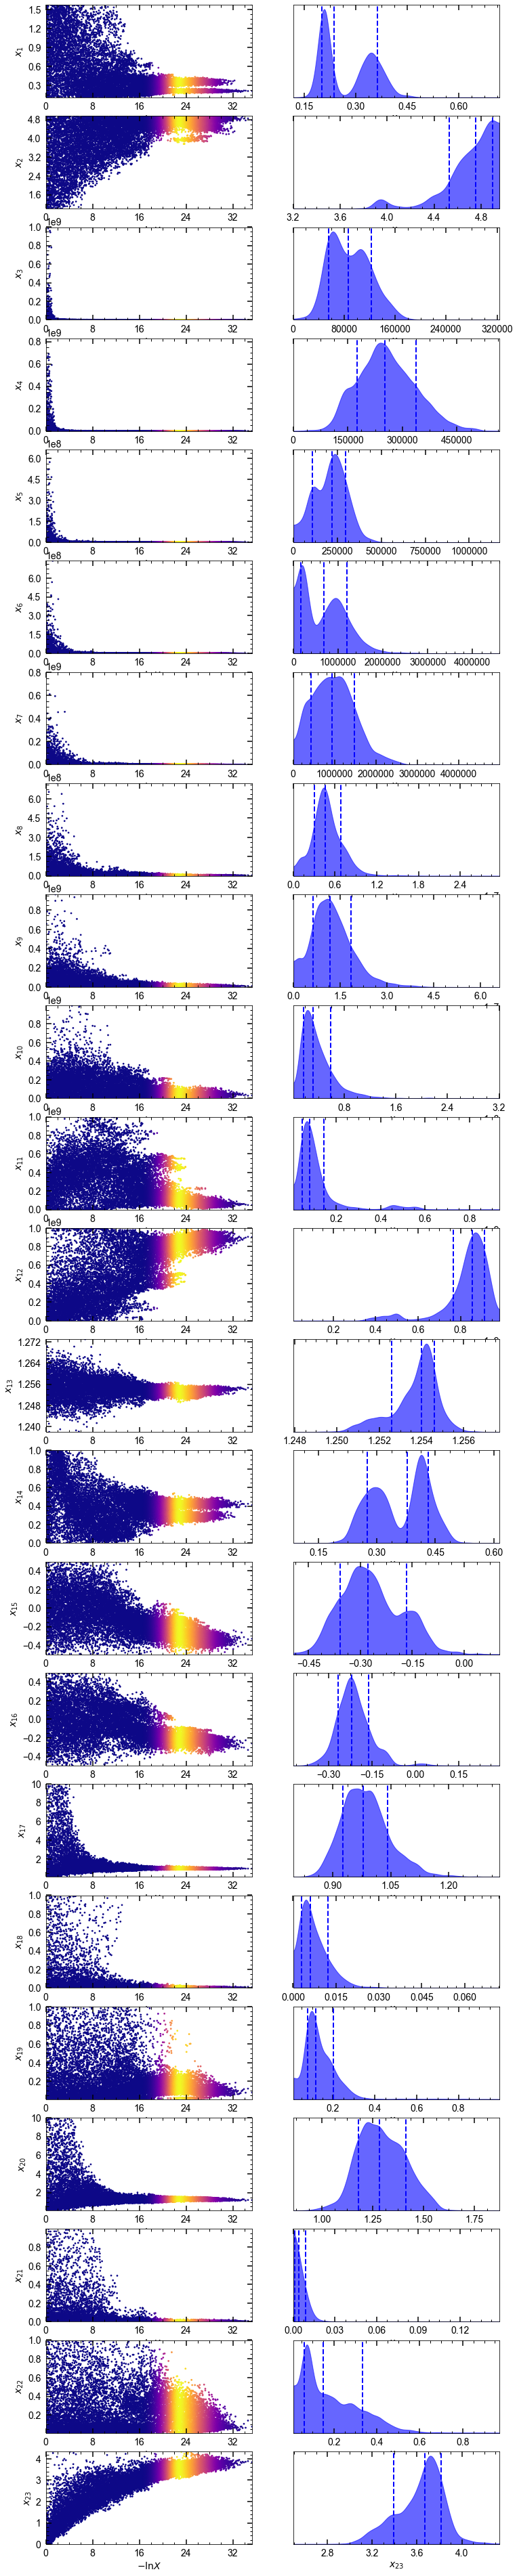

In [54]:
dyplot.traceplot(dres)

In [25]:
dres.samples[-1]
    

array([0.3624067206753928, 4.4029031727020245, 150859.57269693972,
       347757.81273161643, 400280.1743308565, 1010808.3051451549,
       1991257.4532983322, 7730345.818386012, 8627178.542335076,
       194934099.96395776, 552101496.2473512, 232705916.10976714,
       1.2530205635722813, 0.3824274930604845, -0.15871897111614058,
       -0.22077044628608877, 0.9653819653247576, 0.0004938940276470105,
       0.036738565868997174, 1.0982956021931713, 0.012771468725711627,
       0.13329974373565465, 0.06987299955853607, array([2.50976334])],
      dtype=object)

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


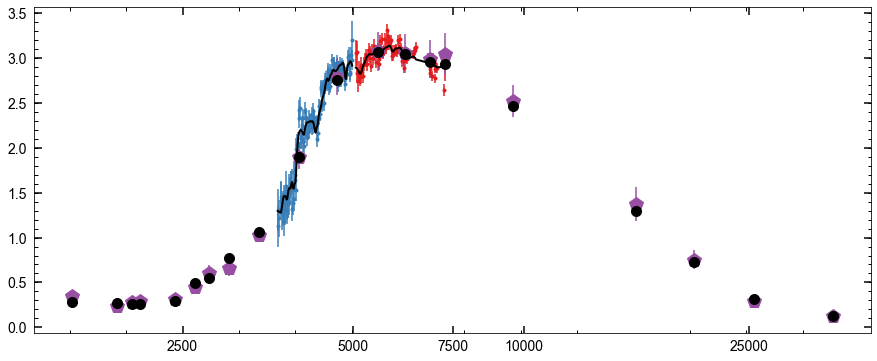

In [55]:
m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1,ba,bb,bl,ra,rb,rl,lwa = dres.samples[-1]
 
Gs = Gen_spec('GND', 21156, 1.2550,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = perr, irac_err = perr*2, decontam = True) 
    
sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage=a*1E9)
sp.set_tabular_sfh(time,sfr)    
    
wave, flux = sp.get_spectrum(tage = a, peraa = True)

Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
        
PC= Full_scale(Gs, Pmfl)

gcal = Calibrate_grism(Gs, PC*Gmfl, [bp1,rp1])

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal

# Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
        
# PC= Full_scale(Gs, Pmfl)

# gcal = Calibrate_grism(Gs, PC*Gmfl, [bp1,rp1])

# bscale = Scale_model(Gs.Bfl,Gs.Ber, Gmfl[0])
# rscale = Scale_model(Gs.Rfl,Gs.Rer, Gmfl[1])

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / gcal[0],Gs.Ber*1E18 / gcal[0],
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  gcal[1],Gs.Rer*1E18 / gcal[1],
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

plt.plot(np.log10(Gs.Bwv_rf), PC*Gmfl[0]*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Gmfl[1]*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)

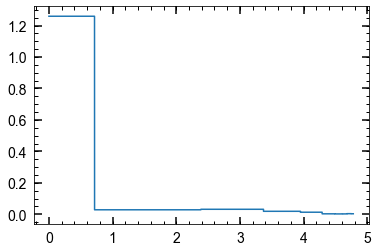

In [56]:
plt.plot(time,sfr)

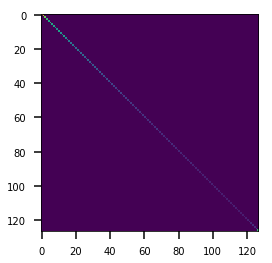

In [277]:
plt.imshow(Covariance(wvs[0], flxs[0], errs[0], ba, bb, bl))

In [43]:
x,px = Get_posterior(np.array(dres.samples[:,22]).astype(float), dres.logwt, dres.logz)

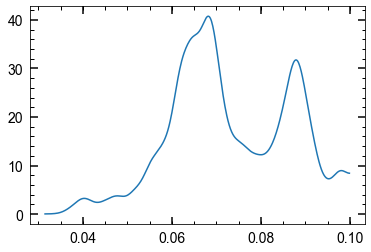

In [44]:
plt.plot(x,px)

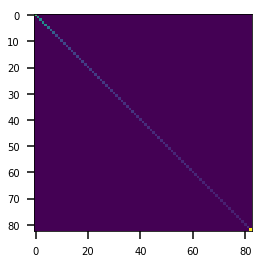

In [278]:
plt.imshow(Covariance(wvs[1], flxs[1], errs[1], ra, rb, rl))

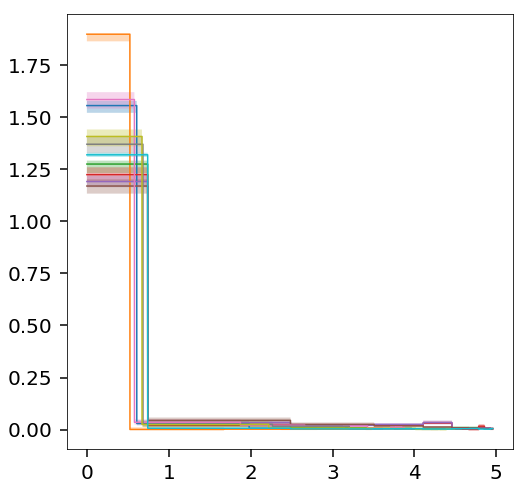

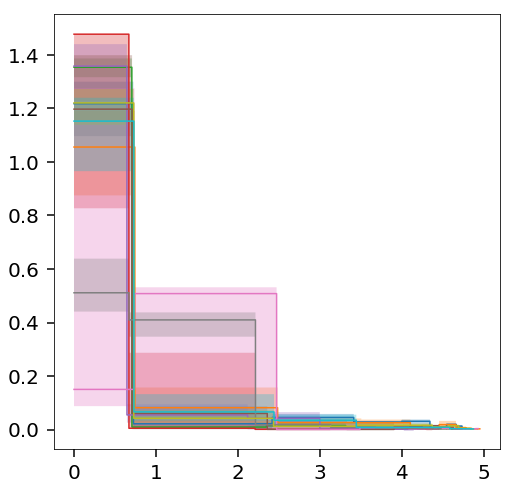

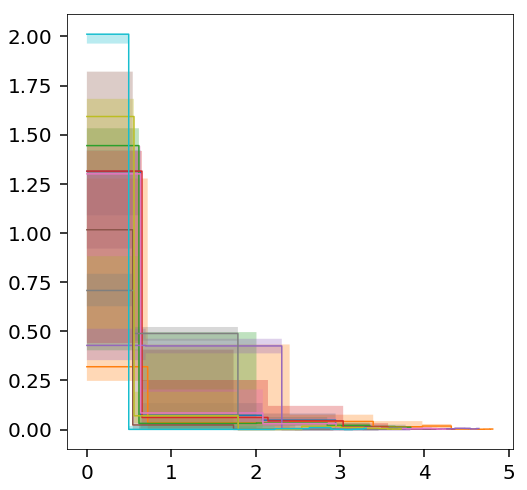

In [16]:
plt.figure(figsize = [8,8])
for i in range(10):
    med,le,he = np.zeros([3,10])
    for ii in range(10):
        x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm{1}.npy'.format(i+1,ii+1))
        med[ii],le[ii],he[ii] = Highest_density_region(px,x)
    
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pa.npy'.format(i+1))
    a,ale,ahe = Highest_density_region(px,x)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), he, maxage = a*1E9)

    plt.plot(time,sfr)
    plt.fill_between(time,sfr - sfr_l, sfr + sfr_h, alpha = 0.3)
  
plt.figure(figsize = [8,8])
for i in range(10):
    med,le,he = np.zeros([3,10])
    for ii in range(10):
        x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm{1}.npy'.format(i+11,ii+1))
        med[ii],le[ii],he[ii] = Highest_density_region(px,x)
    
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pa.npy'.format(i+11))
    a,ale,ahe = Highest_density_region(px,x)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), he, maxage = a*1E9)

    plt.plot(time,sfr)
    plt.fill_between(time,sfr - sfr_l, sfr + sfr_h, alpha = 0.3)

plt.figure(figsize = [8,8])
for i in range(10):
    med,le,he = np.zeros([3,10])
    for ii in range(10):
        x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm{1}.npy'.format(i+21,ii+1))
        med[ii],le[ii],he[ii] = Highest_density_region(px,x)
    
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pa.npy'.format(i+21))
    a,ale,ahe = Highest_density_region(px,x)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), he, maxage = a*1E9)

    plt.plot(time,sfr)
    plt.fill_between(time,sfr - sfr_l, sfr + sfr_h, alpha = 0.3)

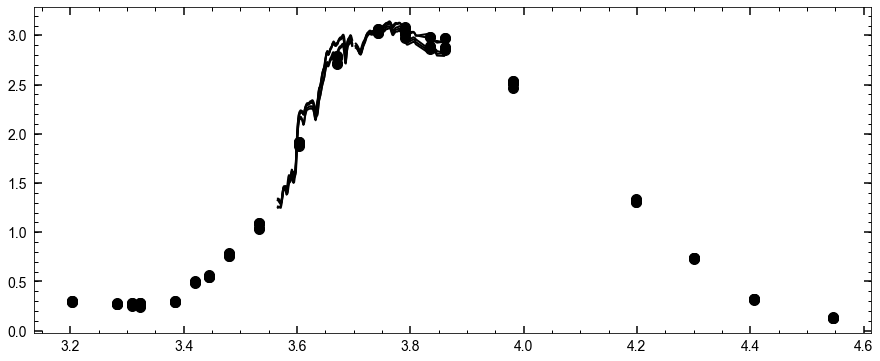

In [37]:
plt.figure(figsize = [15,6])

for i in range(5):
    bfit = np.load('../data/bestfits/GND_21156_tabfit_{0}_bfit.npy'.format(i+1))
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, bfit = np.load(
        '../data/bestfits/GND_21156_tabfit_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage=a*1E9)
    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)

    PC= Full_scale(Gs, Pmfl)

    gcal = Calibrate_grism(Gs, PC*Gmfl, [bp1,rp1])

    def Calibrate_grism(spec, Gmfl, p1):
        linecal = []
        for i in range(len(wvs)):
            lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
            scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
            linecal.append(scale * lines)

        return linecal

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)

    PC= Full_scale(Gs, Pmfl)

    gcal = Calibrate_grism(Gs, PC*Gmfl, [bp1,rp1])

    bscale = Scale_model(Gs.Bfl,Gs.Ber, Gmfl[0])
    rscale = Scale_model(Gs.Rfl,Gs.Rer, Gmfl[1])

#     plt.figure(figsize = [15,6])
#     plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / gcal[0],Gs.Ber*1E18 / gcal[0],
#                     linestyle='None', marker='o', markersize=3, color='#377eb8')
#     plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  gcal[1],Gs.Rer*1E18 / gcal[1],
#                     linestyle='None', marker='o', markersize=3, color='#e41a1c')
#     plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
#                                      linestyle='None', marker='p', markersize=15, color='#984ea3')
#     plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

    plt.plot(np.log10(Gs.Bwv_rf), PC*Gmfl[0]*1E18, 'k', linewidth=2,zorder=5)
    plt.plot(np.log10(Gs.Rwv_rf), PC*Gmfl[1]*1E18, 'k',linewidth=2, zorder=5)
    plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)

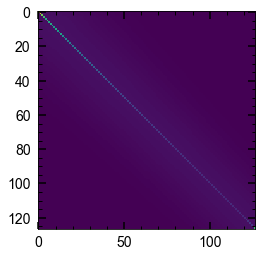

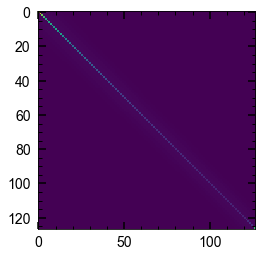

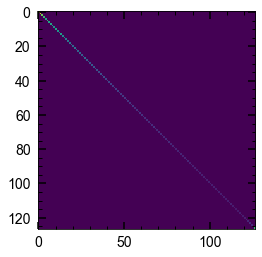

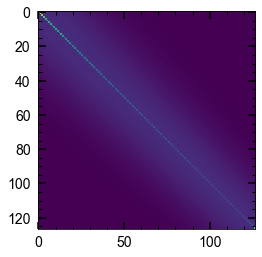

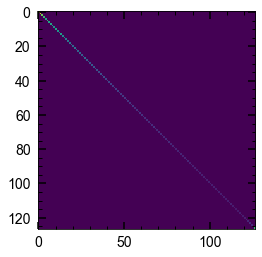

In [40]:
for i in range(5):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pba.npy'.format(i+1,ii+1))
    ba = x[px == max(px)]
    
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pbb.npy'.format(i+1,ii+1))
    bb = x[px == max(px)]
    
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pbl.npy'.format(i+1,ii+1))
    bl = x[px == max(px)]
    
    plt.figure(figsize=[4,4])
    plt.imshow(Covariance(wvs[0], flxs[0], errs[0], ba, bb, bl))

<ErrorbarContainer object of 3 artists>

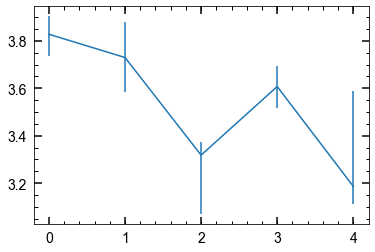

In [45]:
a,ale,ahe = np.zeros([3,5])
for i in range(5):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Plwa.npy'.format(i+1))
    a[i],ale[i],ahe[i] = Highest_density_region(px,x)
    
plt.errorbar(np.arange(5), a, [ale,ahe])

<ErrorbarContainer object of 3 artists>

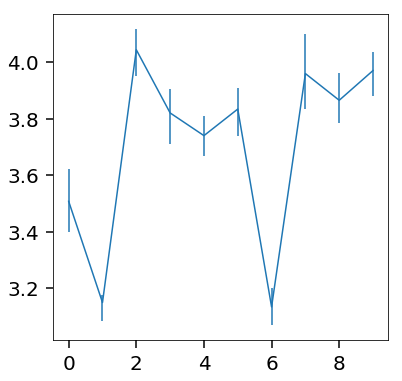

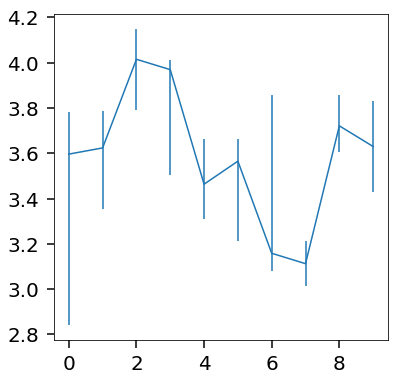

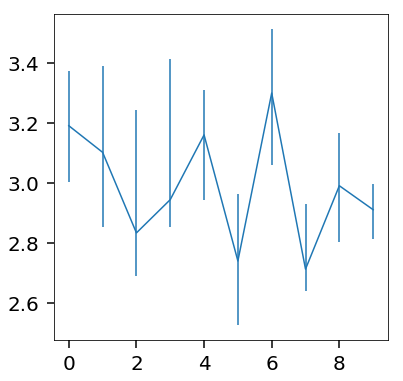

In [14]:
plt.figure(figsize=[6,6])
a,ale,ahe = np.zeros([3,10])
ii=0
for i in range(1,11,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Plwa.npy'.format(i))
    a[ii],ale[ii],ahe[ii] = Highest_density_region(px,x)
    ii += 1
    
plt.errorbar(np.arange(10), a, [ale,ahe])

plt.figure(figsize=[6,6])
a,ale,ahe = np.zeros([3,10])
ii=0
for i in range(11,21,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Plwa.npy'.format(i))
    a[ii],ale[ii],ahe[ii] = Highest_density_region(px,x)
    ii += 1    
plt.errorbar(np.arange(10), a, [ale,ahe])

plt.figure(figsize=[6,6])
a,ale,ahe = np.zeros([3,10])
ii=0
for i in range(21,31,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Plwa.npy'.format(i))
    a[ii],ale[ii],ahe[ii] = Highest_density_region(px,x)
    ii += 1    
plt.errorbar(np.arange(10), a, [ale,ahe])

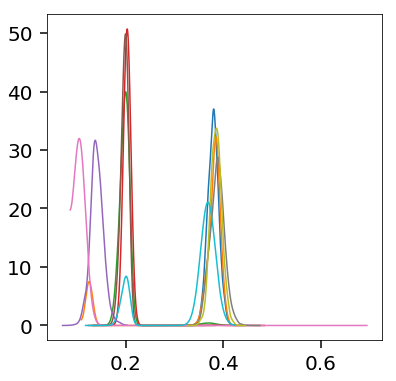

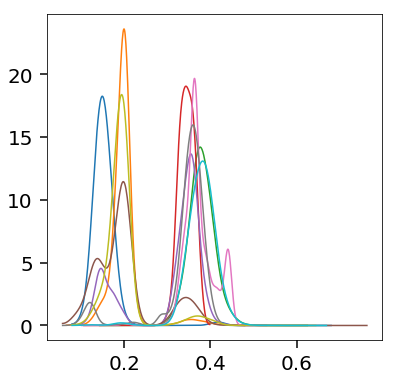

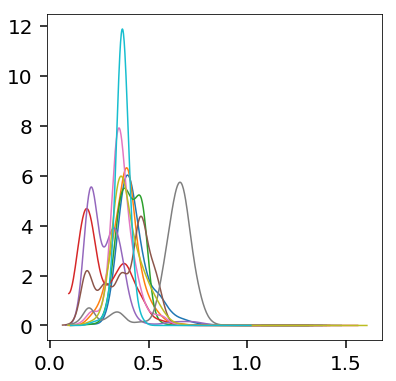

In [12]:
plt.figure(figsize=[6,6])
for i in range(1,11,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm.npy'.format(i))
    plt.plot(x,px)
    
plt.figure(figsize=[6,6])
for i in range(11,21,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm.npy'.format(i))
    plt.plot(x,px)
    
plt.figure(figsize=[6,6])
for i in range(21,31,1):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm.npy'.format(i))
    plt.plot(x,px)